In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import glob
from astropy import units as u
from astropy import constants as const
import time
from astropy.stats import SigmaClip
from dust_extinction.parameter_averages import F99
from spec_modelfit import *

%load_ext autoreload
%autoreload 2

%matplotlib inline

## Load data spectrum and define grid of _empirical spectra_ to compare against:

In [330]:
!open .

In [2]:
# shamelessly stolen out of the astropy specutils library, and not useful here because we're only working in air (!): 
# https://github.com/astropy/specutils/blob/0933a8e271ab1e333337087433cb683da8ab5a54/specutils/utils/wcs_utils.py#L366    
def vac_to_air(wavelength):
    """
    Griesen 2006 reports that the error in naively inverting Eqn 65 is less
    than 10^-9 and therefore acceptable.  This is therefore eqn 67
    """
    wlum = wavelength.to(u.um).value
    nl = (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4))
    return wavelength/nl    

def air_to_vac(wavelength):
    """
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wavelength.to(u.um).value
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wavelength

In [49]:
# newest xshooter spectrum instead
# data = np.loadtxt('../RV/xshooter_oct_medvis.txt', skiprows=1) # optical Oct data
data = np.loadtxt('../RV/xshooter_dec_medvis.txt', skiprows=1) # optical Dec data
# data = np.loadtxt('../RV/xshooter_mednir_dec.txt', skiprows=1) # NIR Dec data


wavelength_object = np.nan_to_num(data[:, 0])
flux_object = np.nan_to_num(data[:, 1])
uncertainty_object = np.nan_to_num(data[:, 2])

# clean up the values where the uncertainty is zero:
wavelength_object = wavelength_object[uncertainty_object != 0]
flux_object = flux_object[uncertainty_object != 0]
uncertainty_object = uncertainty_object[uncertainty_object != 0]

In [50]:
# Do conversion from air (X-shooter) to vacuum (BT Settl) - not necessary for X-shooter library
# wv_obj_vac = air_to_vac(wavelength_object*u.nanometer)
# wavelength_object = wv_obj_vac.value

In [51]:
# set type of data!
optical = True
NIR = False
UV = False

trim = False

In [52]:
# optional: trim the noisy parts - OPTICAL:
if optical==True:
    wavelength_object /= 1000 # to microns
    
    if trim == True:
        flux_object = flux_object[wavelength_object > 670]
        uncertainty_object = uncertainty_object[wavelength_object > 670]
        wavelength_object = wavelength_object[wavelength_object > 670]

In [53]:
# trim the noisy parts - NIR:
if NIR == True:
    flux_object = flux_object[wavelength_object < 2500]
    uncertainty_object = uncertainty_object[wavelength_object < 2500]
    uncertainty_object[np.where(uncertainty_object==0)] = np.median(uncertainty_object)
    wavelength_object = wavelength_object[wavelength_object < 2500]/1000 # to microns    

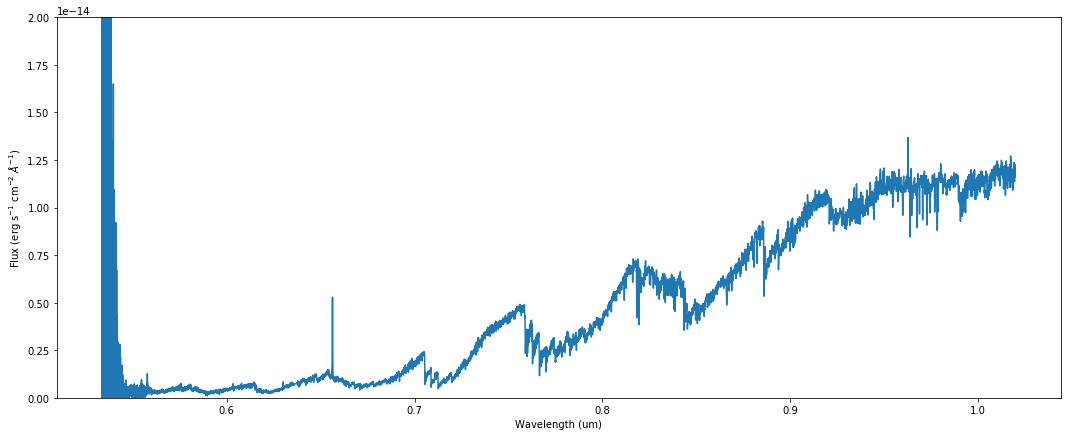

In [54]:
# plot reduced spectrum:
fig = plt.figure(figsize=(18,7))
plt.plot(wavelength_object, flux_object)
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
plt.ylim(0,2e-14)
plt.show()

## Load in an example spectrum from Manara et al. 2013b

In [55]:
# m13_data = fits.getdata('Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_25.843.fits') # nir
# m13_data = fits.getdata('Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_25.457.fits') # uv
m13_data = fits.getdata('Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_26.530.fits') # opt


wavelength_m13 = m13_data[0][0]/1000 # to microns
flux_m13 = m13_data[0][1]
uncertainty_m13 = m13_data[0][2]

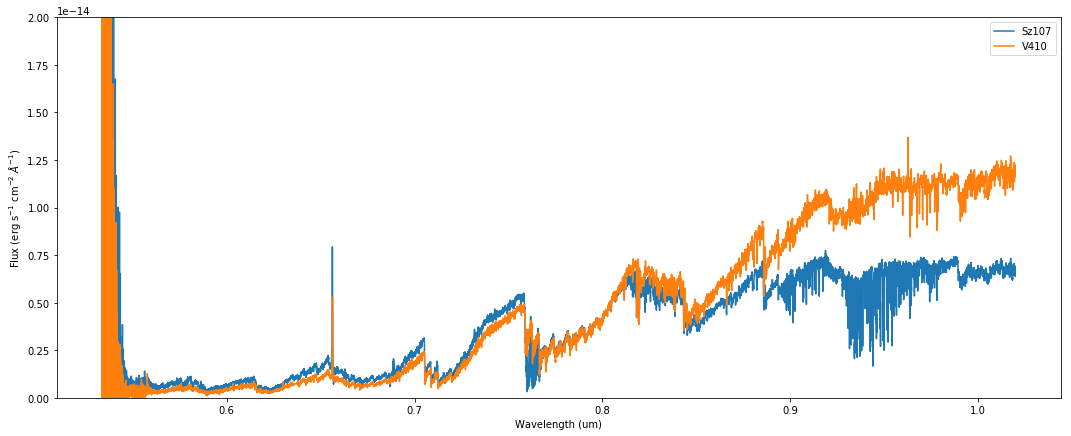

In [56]:
# plot template spectrum:
fig = plt.figure(figsize=(18,7))
# plt.plot(wavelength_m13, flux_m13/np.median(flux_m13[(wavelength_m13 > 1.5) & (wavelength_m13 < 1.7)]), label='Sz107') #normalize to peak of H-band
plt.plot(wavelength_m13, flux_m13, label='Sz107') 


plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')

# plt.plot(wavelength_object, flux_object/np.median(flux_object[(wavelength_object > 1.5) & (wavelength_object < 1.7)]), label='V410') #normalize to peak of H-band
plt.plot(wavelength_object, flux_object, label='V410') 

plt.legend()
plt.ylim(0,2e-14)
# plt.xlim(2.46, 2.5)
plt.show()

In [57]:
# rebin the template to match the same wavelength axis - should be nearly identical:
templ_rebinflux = rebinspec(wavelength_m13, flux_m13, wavelength_object)

# now we can do everything with the x-axis w.r.t. wavelength_object

In [58]:
# try adding some extinction - is that what's occurring here? 
ext = F99(Rv=3.1) 
av = 1.5
spectrum_ext = templ_rebinflux*ext.extinguish(wavelength_object*u.um, Av=av)

/Users/kwardduong/anaconda3/lib/python3.7/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x units are inverse microns")


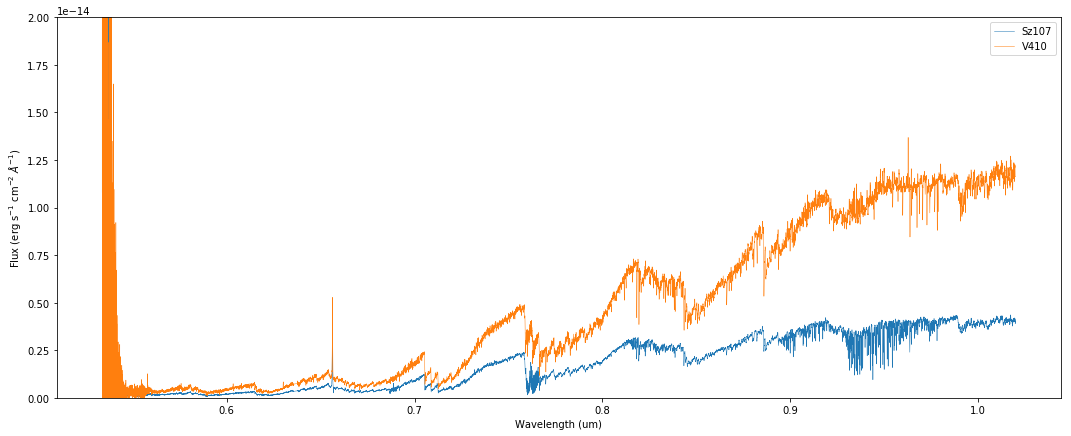

In [59]:
# plot template spectrum:
fig = plt.figure(figsize=(18,7))
# plt.plot(wavelength_object, spectrum_ext/np.median(spectrum_ext), lw=0.5, label='Sz107') #normalize to peak of H-band
plt.plot(wavelength_object, spectrum_ext, lw=0.5, label='Sz107') #not normalized
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
# plt.plot(wavelength_object, flux_object/np.median(flux_object)+0.4, lw=0.5, label='V410') #normalize to peak of H-band
plt.plot(wavelength_object, flux_object, lw=0.5, label='V410') #not normalized
plt.legend()
plt.ylim(0,2e-14)
# plt.xlim(2.46, 2.5)
# plt.xlim(0.65, 0.69)
plt.show()

In [60]:
def sigclip_spec(flux):
    sigclip = SigmaClip(sigma=3, maxiters=10)
    newflux = np.copy(flux)
    filtered_data = sigclip(newflux, copy=True)
    for idx, entry in enumerate(np.where(filtered_data.mask==True)[0]):
        newflux[entry] = np.median(newflux[(entry-25):(entry+25)])
    return newflux

In [61]:
newspec = sigclip_spec(spectrum_ext)
newobj = sigclip_spec(flux_object)

/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


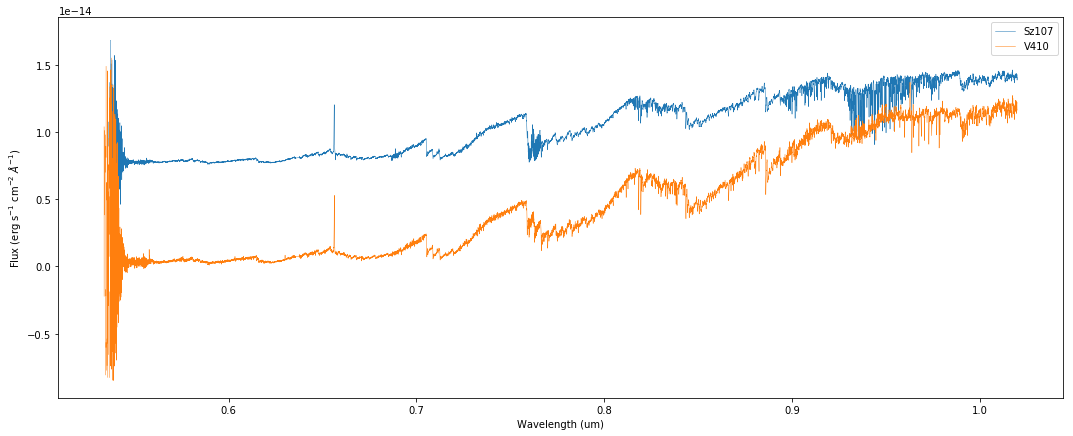

In [62]:
# plot template spectrum:
fig = plt.figure(figsize=(18,7))
plt.plot(wavelength_object, newspec*1.63 + 0.75e-14, lw=0.5, label='Sz107') 
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
plt.plot(wavelength_object, newobj, lw=0.5, label='V410') 
plt.legend()
# plt.ylim(0,4)
# plt.xlim(2.46, 2.5)
plt.show()

In [70]:
templates = ['Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_25.843.fits'] # nir

templates = ['Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_26.530.fits'] # opt


# mini subset for testing
# models = models[:3]

# set up parameters for scaling object radius:
# sclrng = np.arange(0.1, 1.0, 0.2) # solar radii!

# dist = 119.37 # Gaia DR2

# set up extinction parameters:
ext = F99(Rv=3.1) 
avrng = np.arange(0, 4, 0.05) 

# set up range of accretion continuum flux to add to the templates
accretion_continuum_flux = np.linspace(0,1.5e-14,100) # need to measure veiling first!! See page 10 of HH14


len(templates)*len(avrng)*len(accretion_continuum_flux)

8000

In [71]:
def calc_best_template(wavelength_object, flux_object, uncertainty_object, templates, accretion_continuum_flux, avrng):
    
    dof = len(wavelength_object) - 1
    minchi2 = np.zeros(len(templates))
    minradius = np.zeros(len(templates))
    
    # sigma-clip the flux values of the object
    flux_obj_clip = sigclip_spec(flux_object)
    
    # set up dictionary to store chi2 values
    chi2_dict = dict()

    for ii, template in enumerate(templates):
        print(template)
        
        # read in template
        templ_data = fits.getdata(template) 

        wavelength_t = templ_data[0][0]/1000 #convert to um
        flux_t = templ_data[0][1]
        uncertainty_t = templ_data[0][2]
        
        # rebin the template to match the same wavelength axis - should be nearly identical:
        templ_rebinflux = rebinspec(wavelength_t, flux_t, wavelength_object)

        # sigma-clip the flux values of the template
        flux_t_clip = sigclip_spec(templ_rebinflux)

        for acc_cont in accretion_continuum_flux:
            
            # add accretion luminosity to template:
            flux_t_clip_wacc = flux_t_clip + acc_cont
            
            for av in avrng:
                #print(av)
                
                # add extinction to the model 
                spectrum_ext = flux_t_clip_wacc*ext.extinguish(wavelength_object*u.um, Av=av)

                # calculate chi2 value for the extincted model
                tmp_chi2 = np.nansum(((flux_obj_clip - spectrum_ext)/uncertainty_object)**2) / dof 
                
                # add dictionary entry with tuple and chi2 value:
                chi2_dict[(template, acc_cont, av)] = tmp_chi2
                #print(tmp_chi2)


    minchi2 = min(chi2_dict.values())
    
    result = [k for k,v in chi2_dict.items() if v==minchi2]
    
        
    return result, minchi2

In [72]:
t0 = time.time()

result, chi2 = calc_best_template(wavelength_object, flux_object, uncertainty_object, templates, accretion_continuum_flux, avrng)
    
t1 = time.time()

print("Time taken: ", np.round((t1-t0)/60., 2), " minutes")

/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_26.530.fits


/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x units are inverse microns")


Time taken:  0.46  minutes


In [74]:
result, chi2

([('Extinction/Manara2013_Library/Sz107/ADP.2014-05-16T21_35_26.530.fits',
   1.5151515151515151e-16,
   0.0)],
 3411.4334573498563)

## Use best-fit values to examine template match:

In [75]:
templ_data = fits.getdata(result[0][0]) 

wavelength_t = templ_data[0][0]/1000 #convert to um
flux_t = templ_data[0][1]
uncertainty_t = templ_data[0][2]
        
# rebin the template to match the same wavelength axis - should be nearly identical:
templ_rebinflux = rebinspec(wavelength_t, flux_t, wavelength_object)

# sigma-clip the flux values of the template
flux_t_clip = sigclip_spec(templ_rebinflux)
flux_t_clip_wacc = flux_t_clip + result[0][1]

# and sigma-clip the object:
newobj = sigclip_spec(flux_object)

spectrum_ext = flux_t_clip_wacc*ext.extinguish(wavelength_object*u.um, Av=result[0][2])

/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/kwardduong/

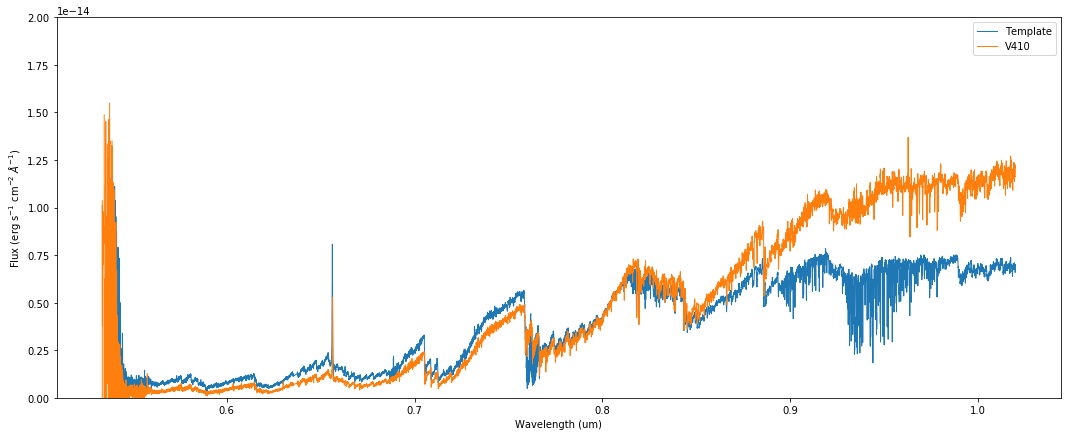

In [76]:
# plot reduced spectrum:
fig = plt.figure(figsize=(18,7))

plt.plot(wavelength_object, spectrum_ext, lw=1, label='Template')
plt.plot(wavelength_object, newobj, lw=1, label='V410')
plt.legend()
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
# plt.xlim(0.805,0.83)
# plt.xlim(0.75, 0.79)
# plt.xlim(0.8, 0.9)
plt.ylim(0,2e-14)
plt.show()

In [77]:
# Just out of curiosity - normalizing 

/Users/kwardduong/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


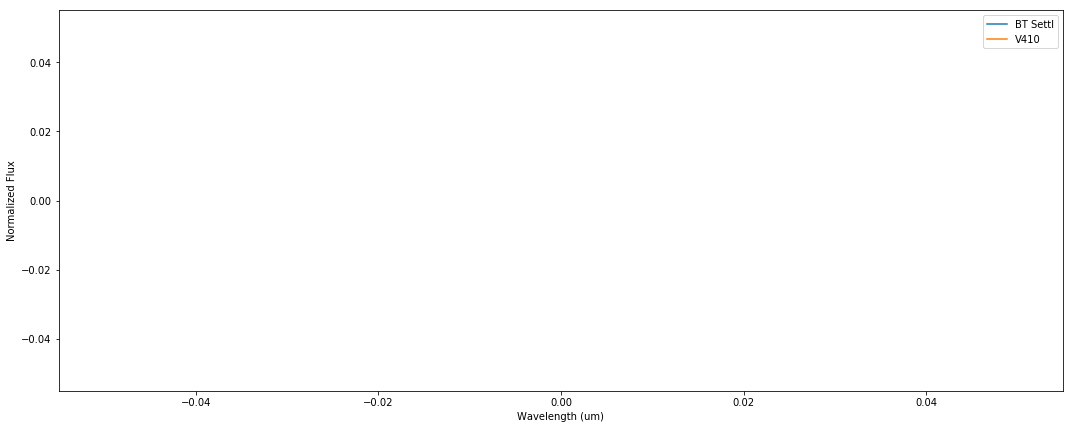

In [78]:
fig = plt.figure(figsize=(18,7))

plt.plot(wavelength_object, spectrum_ext/np.median(spectrum_ext), label='Template')
plt.plot(wavelength_object, newobj/np.median(newobj), label='V410')
plt.legend()
plt.xlabel('Wavelength (um)')
plt.ylabel(r'Normalized Flux')
# plt.xlim(0.805,0.83)
# plt.xlim(0.75, 0.79)
# plt.xlim(1.6, 1.7)
plt.show()

In [259]:
## Save the output such that the these can be used for cross-correlating elsewhere:
np.savetxt('../RV/Empirical_Xshooter_forXCorr_Dec_NIR.txt', np.c_[wavelength_object, flux_object, uncertainty_object, spectrum_ext])

## A quick RV test...

In [130]:
from PyAstronomy import pyasl

In [176]:
fit_region = (wavelength_object > 0.95) & (wavelength_object < 0.99)
fit_region = (wavelength_object > 0.7) & (wavelength_object < 1.0)

In [177]:
# normalize data:
dw = wavelength_object[fit_region]
df = (flux_object[fit_region])/np.median(flux_object[fit_region])

# template:
tw = wavelength_object[fit_region] # since we've resampled to the same wavelength axis
tf = (spectrum_ext[fit_region]/np.median(spectrum_ext[fit_region]))

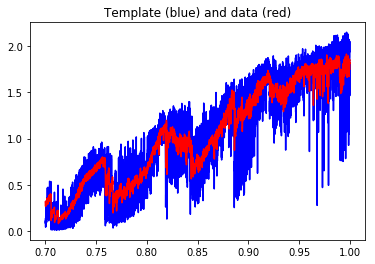

In [178]:
# Plot template and data
plt.title("Template (blue) and data (red)")
plt.plot(tw, tf, 'b-')
plt.plot(dw, df, 'r-')
# plt.xlim(2.28, 2.32)
plt.show()

In [179]:
# Carry out the cross-correlation.
# The first and last 20 points of the data are skipped.
rv, cc = pyasl.crosscorrRV(dw, df, tw, tf, -50., 50., 10/100., skipedge=10, mode='doppler')

Cross-correlation function is maximized at dRV =  18.000000000000966  km/s
  A red-shift with respect to the template


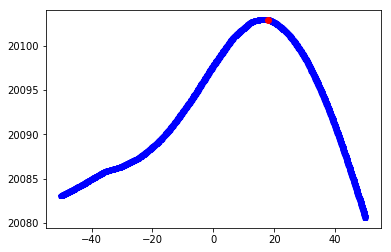

In [180]:
# Find the index of maximum cross-correlation function
maxind = np.argmax(cc)

print("Cross-correlation function is maximized at dRV = ", rv[maxind], " km/s")
if rv[maxind] > 0.0:
  print("  A red-shift with respect to the template")
else:
  print("  A blue-shift with respect to the template")

plt.plot(rv, cc, 'bp-')
plt.plot(rv[maxind], cc[maxind], 'ro')
plt.show()
